# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything

## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd


In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape

print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [3]:
component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']

# Molar masses (g/mol)
molar_masses = {
    'YH': 1.0,
    'YH2': 2.0,
    'YO': 8.0,
    'YO2': 16.0,
    'YOH': 9.0,
    'YH2O': 10.0,
    'YHO2': 17.0,
    'YH2O2': 18.0
}


file_key_map = {
    'YH': 'YH filename',
    'YH2': 'YH2 filename',
    'YO': 'YO filename',
    'YO2': 'YO2 filename',
    'YOH': 'YOH filename',
    'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename',
    'YH2O2': 'YH2O2 filename'
}

In [4]:
# Load Snapshot Data
def load_dataset(data_path, component_names, file_key_map, Ny, Nx, subsample_x, subsample_y):
    with open(f"{data_path}" + '/info.json', 'r') as f:
        metadata = json.load(f)

    # Sta roba da quando facevo il caso non reattivo
    available_components = []
    available_indices = []
    for c_idx, comp_name in enumerate(component_names):
        filename_key = file_key_map[comp_name]
        if filename_key in metadata['local'][0]:
            available_components.append(comp_name)
            available_indices.append(c_idx)

    print(f"  Available components in dataset: {available_components}")
    n_available = len(available_components)

    # Initialize tensor with only available components: (x, y, components, time)
    tensor = np.zeros((Ny_sub, Nx_sub, n_available, n_snapshots))
    for t_idx in range(n_snapshots):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(available_components, available_indices)):
            filename_key = file_key_map[comp_name]
            filename = metadata['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            # Convert mass fraction to molar fraction by dividing by molar mass
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]

    return tensor
tensors = {path: load_dataset(path, component_names, file_key_map, Ny, Nx, subsample_x, subsample_y)
           for path in data_paths}

  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [5]:
for dataset_path, tensor in tensors.items():
    if "nonreact" not in dataset_path:
        print("\n" + "=" * 80)
        print(f"Dataset: {dataset_path}")
        print("=" * 80)
        print(f"{'Component':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 80)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor[:, :, c_idx, :]
            mean_val = np.mean(component_data)
            std_val = np.std(component_data)
            min_val = np.min(component_data)
            max_val = np.max(component_data)
            
            print(f"{comp_name:<15} {mean_val:<12.6e} {std_val:<12.6e} {min_val:<12.6e} {max_val:<12.6e}")
        
        print("-" * 80)
        
        # Overall tensor stats
        print(f"Overall Tensor Statistics:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Total elements: {tensor.size:,}")
        print(f"  Memory size: {tensor.nbytes / (1024**2):.2f} MB")
        print(f"  Global mean: {np.mean(tensor):.6e}")
        print(f"  Global std:  {np.std(tensor):.6e}")
        print(f"  Global min:  {np.min(tensor):.6e}")
        print(f"  Global max:  {np.max(tensor):.6e}")
        print("=" * 80)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

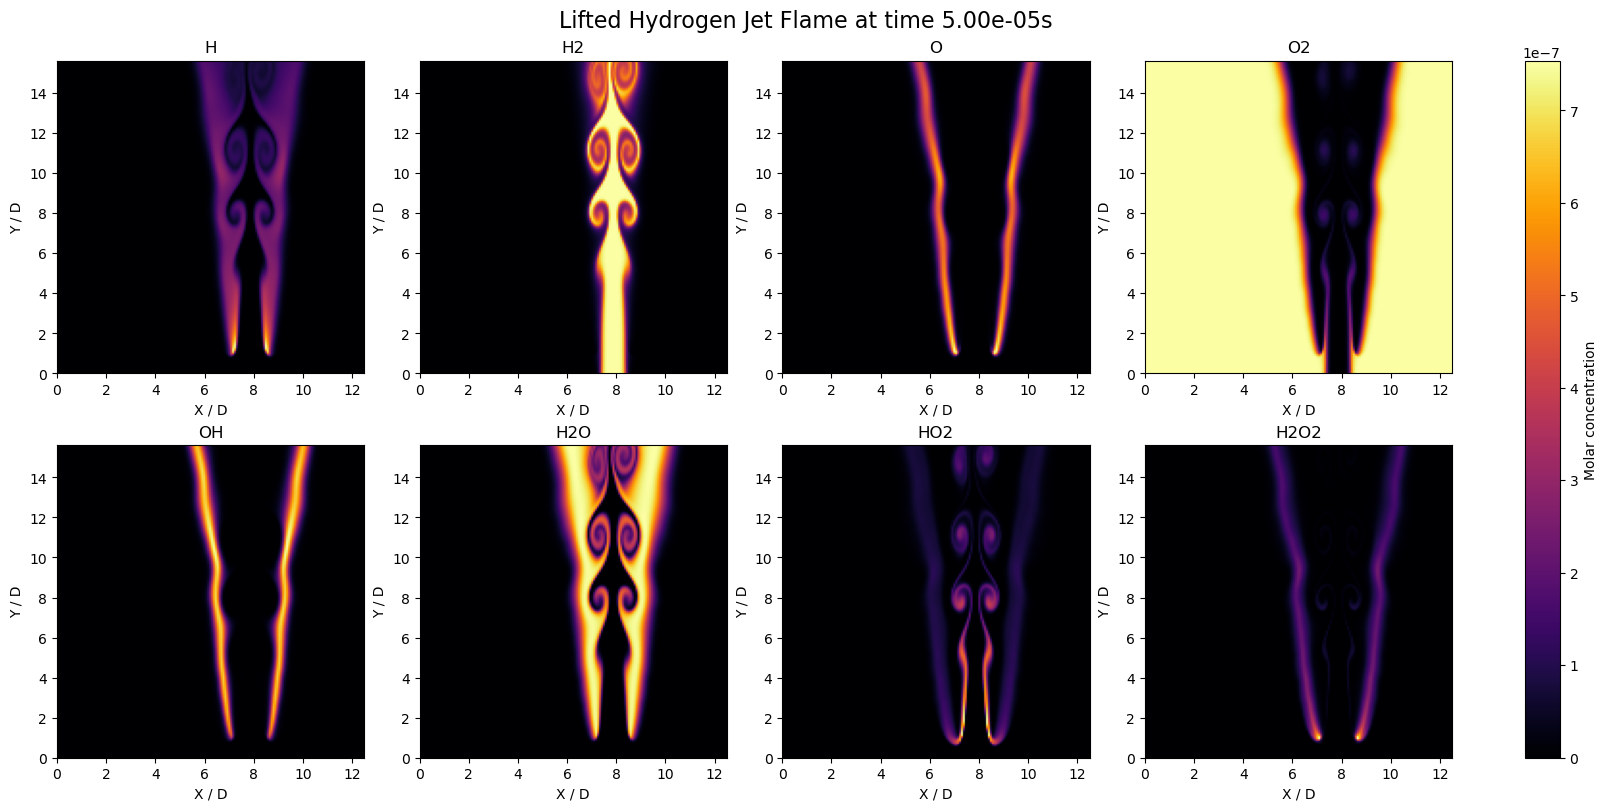

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/original_data_t10.png')
plt.show()


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [7]:
component_means_all = {}
epsilon = 1e-12  

for dataset_path, tensor in tensors.items():
    
    print("\n" + "=" * 50)
    print(f"Dataset: {dataset_path}")
    print("Applying log scaling and centering to chemical species...")
    print("=" * 50)
    print(f"{'Component':<15} {'Mean (after log)':<20} {'Std':<15} {'Max (log)':<15}")
    print("-" * 70)
    
    n_components = tensor.shape[2]
    
    for c_idx, comp_name in enumerate(component_names):        
        component_data = tensor[:, :, c_idx, :]

        component_data = tensor[:, :, c_idx, :]
        component_data = np.log10(np.maximum(component_data, 1e-12))
 
        tensor[:, :, c_idx, :] = component_data
        component_means_all[comp_name] = {
            "mean_after_log": mean_val,
            "std_after_log": std_val
        }

        print(f"{comp_name:<15} {mean_val:<20.3e} {std_val:<15.3e} {component_data.max():<15.3e}")

print("\nLog scaling and centering complete.\n")



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Applying log scaling and centering to chemical species...
Component       Mean (after log)     Std             Max (log)      
----------------------------------------------------------------------
YH              1.742e-08            4.961e-08       -2.312e+00     
YH2             1.742e-08            4.961e-08       -4.882e-01     
YO              1.742e-08            4.961e-08       -2.721e+00     
YO2             1.742e-08            4.961e-08       -1.837e+00     
YOH             1.742e-08            4.961e-08       -2.520e+00     
YH2O            1.742e-08            4.961e-08       -1.626e+00     
YHO2            1.742e-08            4.961e-08       -4.965e+00     
YH2O2           1.742e-08            4.961e-08       -6.112e+00     

Log scaling and centering complete.



In [8]:
for dataset_path, tensor in tensors.items():
    print("\n" + "=" * 80)
    print(f"Dataset: {dataset_path}")
    print("=" * 80)
    print(f"{'Component':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
    print("-" * 80)        
    for c_idx, comp_name in enumerate(component_names):
        component_data = tensor[:, :, c_idx, :]
        mean_val = np.mean(component_data)
        std_val = np.std(component_data)
        min_val = np.min(component_data)
        max_val = np.max(component_data)
        
        print(f"{comp_name:<15} {mean_val:<12.6e} {std_val:<12.6e} {min_val:<12.6e} {max_val:<12.6e}")
    
    print("-" * 80)
    
    # Overall tensor stats
    print(f"Overall Tensor Statistics:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Total elements: {tensor.size:,}")
    print(f"  Memory size: {tensor.nbytes / (1024**2):.2f} MB")
    print(f"  Global mean: {np.mean(tensor):.6e}")
    print(f"  Global std:  {np.std(tensor):.6e}")
    print(f"  Global min:  {np.min(tensor):.6e}")
    print(f"  Global max:  {np.max(tensor):.6e}")
    print("=" * 80)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              -9.212932e+00 3.771220e+00 -1.200000e+01 -2.311914e+00
YH2             -7.728262e+00 4.357472e+00 -1.200000e+01 -4.881567e-01
YO              -9.351383e+00 3.347451e+00 -1.200000e+01 -2.721346e+00
YO2             -2.309645e+00 9.944892e-01 -6.898776e+00 -1.836764e+00
YOH             -9.191934e+00 3.512371e+00 -1.200000e+01 -2.520002e+00
YH2O            -8.616590e+00 4.312756e+00 -1.200000e+01 -1.626106e+00
YHO2            -9.961307e+00 2.581884e+00 -1.200000e+01 -4.964688e+00
YH2O2           -1.060957e+01 1.974835e+00 -1.200000e+01 -6.112443e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  

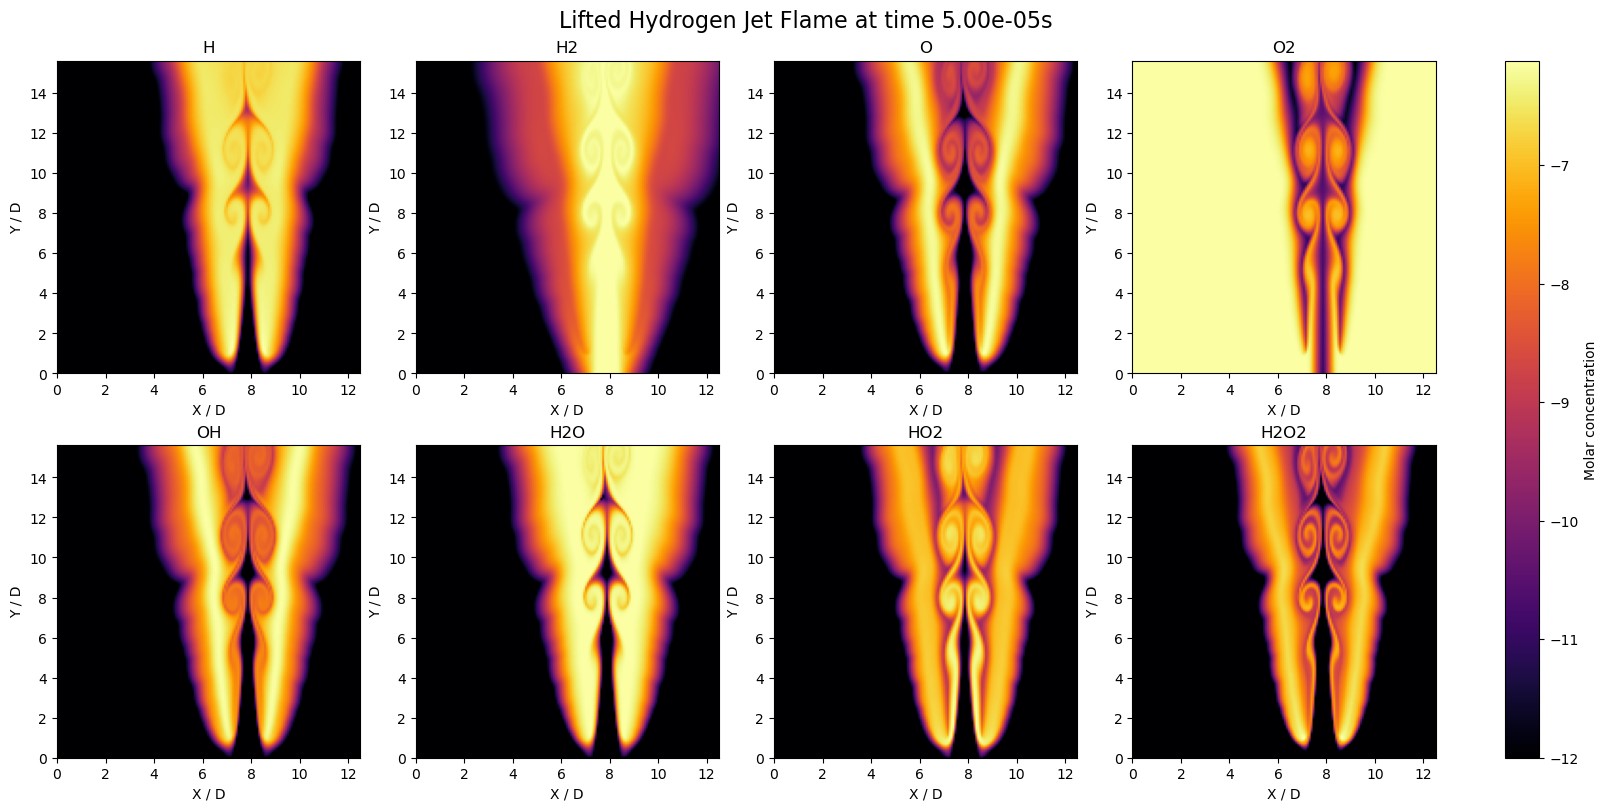

In [9]:
Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/processed_data_t10.png')
plt.show()


## PCA classica

Per prima cosa bisogna implementare la PCA nella sua forma piu' tradizionale

(6400000, 8)
Total spatial features: 6400000

Top modes energy content:
  Mode  1:  99.90%
  Mode  2:   0.04%
  Mode  3:   0.04%
  Mode  4:   0.01%
  Mode  5:   0.01%
  Mode  6:   0.00%
  Mode  7:   0.00%
  Mode  8:   0.00%


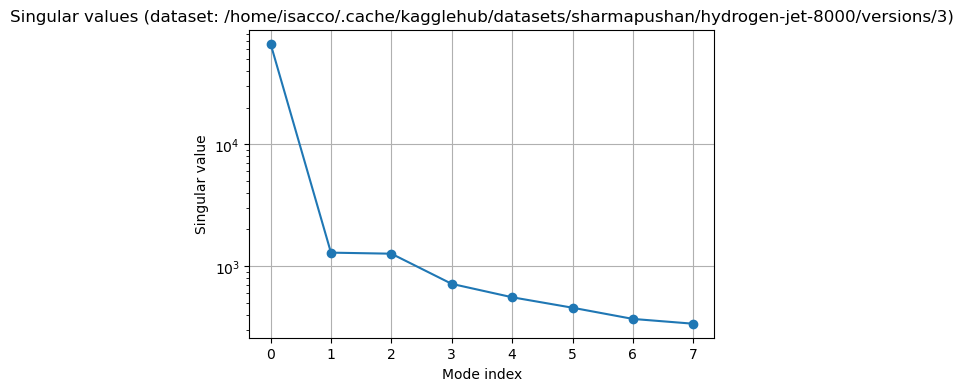

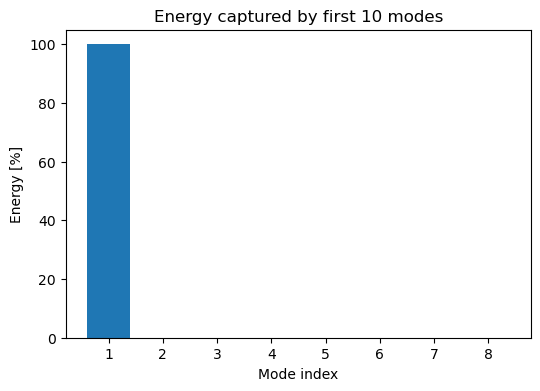

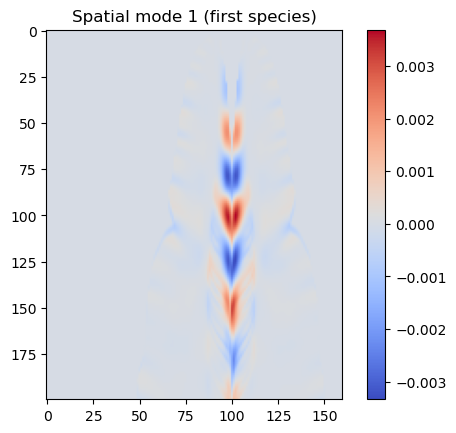

In [10]:
for dataset_path, tensor in tensors.items():
    X =  tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    Phi = U
    print(U.shape)
    # Temporal coefficients (principal components)
    T = np.diag(sigma) @ V

    energy = sigma**2
    energy_fraction = energy / np.sum(energy)

    print(f"Total spatial features: {X.shape[0]}")
    print("\nTop modes energy content:")
    for i in range(8):
        print(f"  Mode {i+1:2d}: {energy_fraction[i]*100:6.2f}%")

    # --- Plot singular values and energy ---
    plt.figure(figsize=(6,4))
    plt.semilogy(sigma, 'o-')
    plt.title(f"Singular values (dataset: {dataset_path})")
    plt.xlabel("Mode index")
    plt.ylabel("Singular value")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.bar(np.arange(1, 9), energy_fraction[:10]*100)
    plt.title("Energy captured by first 10 modes")
    plt.xlabel("Mode index")
    plt.ylabel("Energy [%]")
    plt.show()

    phi1 = Phi[:, 2].reshape(Ny_sub, Nx_sub, 1, 200)
    plt.imshow(phi1[:, :, :, 0], cmap='coolwarm')  # e.g. first species
    plt.title("Spatial mode 1 (first species)")
    plt.colorbar()
    plt.show()

In [11]:
# Analyze contribution of original components to each principal component
for dataset_path, tensor in tensors.items():
    X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    
    # V contains the loadings (components x modes)
    # Each row of V corresponds to a mode, each column to an original component
    loadings = V.T  # Now shape is (n_components x n_modes)
    
    summary_data = []
    
    for mode in range(8):
        mode_vector = np.abs(loadings[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get top 3 species
        top3_indices = np.argsort(rel_contrib)[:][::-1]
        
        top_species = []
        for idx in top3_indices:
            top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
        
        summary_data.append({
            'Mode': mode + 1,
            '1st Species': top_species[0],
            '2nd Species': top_species[1],
            '3rd Species': top_species[2],
            '4rd Species': top_species[3],
            '5rd Species': top_species[4],
            '6rd Species': top_species[5],
            '7rd Species': top_species[6],
            '8rd Species': top_species[7],
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {dataset_path}")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("="*80)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species  3rd Species   4rd Species  5rd Species   6rd Species  7rd Species 8rd Species
    1 YH2O2 (12.5%) YHO2 (12.5%) YH2O (12.5%)   YOH (12.5%)  YO2 (12.5%)    YO (12.5%)  YH2 (12.5%)  YH (12.5%)
    2  YH2O (17.7%)   YO (17.6%)  YH2 (17.2%)  YHO2 (17.2%) YH2O2 (7.7%)     YH (7.7%)   YO2 (7.4%)  YOH (7.4%)
    3   YOH (18.5%)  YO2 (18.4%)   YH (16.2%) YH2O2 (16.2%)  YHO2 (8.8%)    YH2 (8.8%)  YH2O (6.6%)   YO (6.6%)
    4 YH2O2 (22.5%)   YH (22.4%) YH2O (12.3%)    YO (12.2%)   YO2 (9.0%)    YOH (8.9%)   YH2 (6.4%) YHO2 (6.4%)
    5    YO (14.5%) YH2O (14.3%)   YH (13.3%) YH2O2 (13.2%)  YO2 (11.8%)   YOH (11.7%) YHO2 (10.6%) YH2 (10.5%)
    6   YH2 (17.2%) YHO2 (16.7%)  YOH (15.7%)   YO2 (15.5%)   YH (13.4%) YH2O2 (13.2%)    YO (4.4%) YH2O (3.9%)
    7  YHO2 (18.4%)  YH2 (18.3%)   YO (16.4%)  YH2O (15.9%) YH2O2 (9.0%)     YH (8.8%)   YO2 

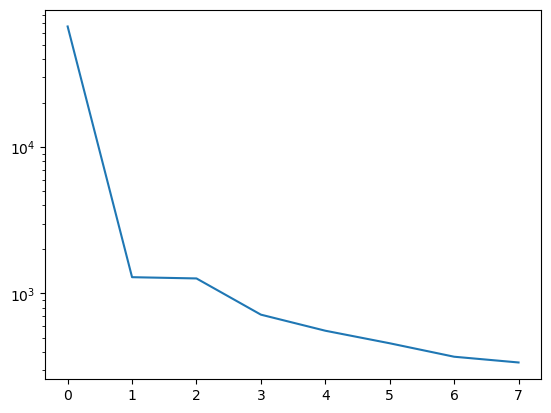

In [12]:
plt.plot(sigma)
plt.yscale("log")

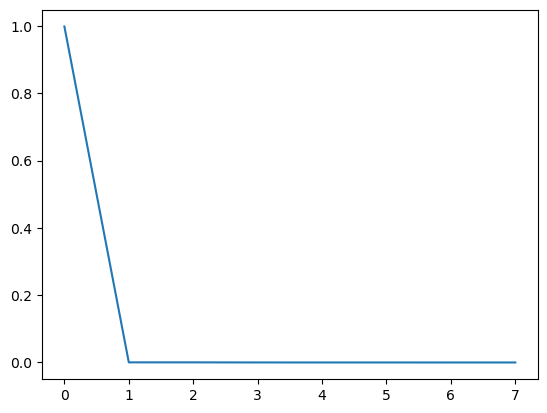

In [13]:
variance_explained = sigma**2 / np.sum(sigma**2)
plt.plot(variance_explained)